# PyTorch Model Deployment


So far, the FoodVision Mini Project has only been accessible to us. Hence, the goal of this chapter is to deploy our FoodVision Mini model to the internet as a usable app

### What is Machine Learning model deployment?

Machine learning model deployment is the process of making your machine learning model accessible to someone or something else, allowing said user to interact with the model in some way.

This can come in the form of a person, or a program, app, or model that interacts with our model. Machine learning model deployment involves making your model available to someone or something else.

### Why deploy a Machine Learning model?

While evaluating a model on a well crafted test set, or visualizing its results can give a good indicator as to a model's performance, one can never truly know the model's performance unless it is released in the wild.

Having people who have never used your model interact with it often reveals edge cases never thought of during training. Model deployment helps figure out errors in models that are not obvious during training/testing.

### Different types of Machine Learning model deployment

There are many types of model deployment, but when deciding the optimal type, one has to start with the question:

> What is the most ideal scenario for my machine learning model to be used?

And then work backwards from there. In the case of FoodVision Mini, the ideal scenario would entail:

* Someone takes a photo on a mobile device
* The prediction comes back fast

Therefore, this yields two important criteria:
1. The model should work on a mobile device (leading to compute constraints)
2. The model should make predictions fast (because a slow app is not very useful)

When dealing with this criteria, we have to also account for where is the data going to be stored, and if the predictions can be returned immediately or later.

Because of all these criteria to tackle, it is often better to start with the most ideal use case, and work backwards from there.

### Where is it going to go?

Where does the model live when it is deployed?

The main debate here is whether is lives on-device (also called edge/in the browser) or on the cloud (a computer/sever that isn't the actual device someone/something calls the model from).

Both scenarios have their pros and cons.

| Deployment Location | Pros                                                       | Cons                                                                                                               |
|---------------------|------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------|
| On-device           | Can be very fast (since no data leaves the device)         | Limited compute power (larger models take longer to run)                                                           |
|                     | Privacy preserving (again no data has to leave the device) | Limited storage space (smaller model size required)                                                                |
|                     | No internet connection required (sometimes)                | Device-specific skills often required                                                                              |
| On cloud            | Near unlimited compute power (can scale up when needed)    | Costs can get out of hand (if proper scaling limits aren't enforced)                                               |
|                     | Can deploy one model and use everywhere (via API)          | Predictions can be slower due to data having to leave device and predictions having to come back (network latency) |
|                     | Links into existing cloud ecosystem                        | Data has to leave device (this may cause privacy concerns)                                                         |

Given these considerations, there is an evident trade-off between performance and prediction time with on-device being less performant but faster while on cloud offers a more performant model that requires more computation and storage, leading to longer prediction times.

### How is it going to function?

When deploying the machine learning model, one has to decide whether immediate predictions, or slightly delayed predictions are desirable. These scenarios are generally referred to as:

* Online (real-time): Predictions/inference happen immediately.
* Offline (batch): Predictions/inference happen periodically.

The periodic predictions can have a varying timescale too, from seconds to hours or days.

These approaches can be mixed too, where our inference pipeline can happen online while the training pipeline happens in an offline fashion, which is what has been done throughout the course.

### Ways to deploy a machine learning model

Here are a couple of options:

| Tool/Resource                                  | Deployment Type               |
|------------------------------------------------|-------------------------------|
| Google's ML Kit                                | On-device (Android and iOS)   |
| Apple's Core ML and coremltools Python package | On-device (all Apple devices) |
| Amazon Web Service's (AWS) Sagemaker           | Cloud                         |
| Google Cloud's Vertex AI                       | Cloud                         |
| Microsoft's Azure Machine Learning             | Cloud                         |
| Hugging Face Spaces                            | Cloud                         |
| API with FastAPI                               | Cloud/self-hosted server      |
| API with TorchServe                            | Cloud/self-hosted server      |
| ONNX (Open Neural Network Exchange)            | Many/general                  |

The chosen option is highly dependent on what is being built/who are you working with.

One of the best small and simple ways is to turn your machine learning model into a demo app with Gradio and then deploy it on Hugging Face Spaces.


### What will be covered

The goal is to deploy the FoodVision Model via a demo Gradio app with the following metrics:
1. Performance: 95% accuracy
2. Speed: real-time inference of 30FPS+ (each prediction has a latency of lower than ~0.03s)

## 0. Setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Could not find going_modular scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Zero-To-Mastery-Pytorch
    !mv Zero-To-Mastery-Pytorch/Fundamentals/going_modular .
    !mv Zero-To-Mastery-Pytorch/Fundamentals/helper_functions.py .
    !rm -rf Zero-To-Mastery-Pytorch
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it
[INFO] Could not find going_modular scripts. Downloading them from GitHub.
Cloning into 'Zero-To-Mastery-Pytorch'...
remote: Enumerating objects: 699, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 699 (delta 37), reused 7 (delta 2), pack-reused 617 (from 1)
Receiving objects: 100% (699/699), 133.90 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (151/151), done.
Updating files: 100% (353/353), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

In [4]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini Model deployment experiment outline

The ideal model performance would be for it to perform as close to real-time as possible.

For our use, real-time would be approximately ~30FPS (frames per second) because that is approximately how fast the human eye can see.

Regarding metrics, it would be desirable for the model to perform with a 95% accuracy. Higher accuracy would be appreciated, but this might sacrifice speed.

Therefore, the goals are:
1. **Performance**: 95% accuracy
2. **Speed**: A model that can classify an image at ~30FPS

The emphasis for the model deploymen is on speed where we would rather slightly sacrifice accuracy to achieve the desired speed rather than the other way around.

As benchmarks, we will the the best performing models from previous sections:
1. EffNetB2 Feature Extractor
2. ViT-B/16 Feature Extractor

## 3. Creating an EffNetB2 feature extractor

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 127MB/s] 


In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

EffNetB2 originally has 1000 output classes. For our use case, we need to change the classifier head to 3 given that our `out_features=3`.

In [8]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

### 3.1 EffNetB2 Feature Extractor Function

In [9]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms



In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [11]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2



In [12]:
from going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### 3.3 Training EffNetB2 feature extractor

In [13]:
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.1526 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.1323 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.1028 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.0926 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.1044 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.0817 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.0748 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.0989 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.0813 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.0628 | test_acc: 0.9625


### 3.4 EffNetB2 Loss Curves

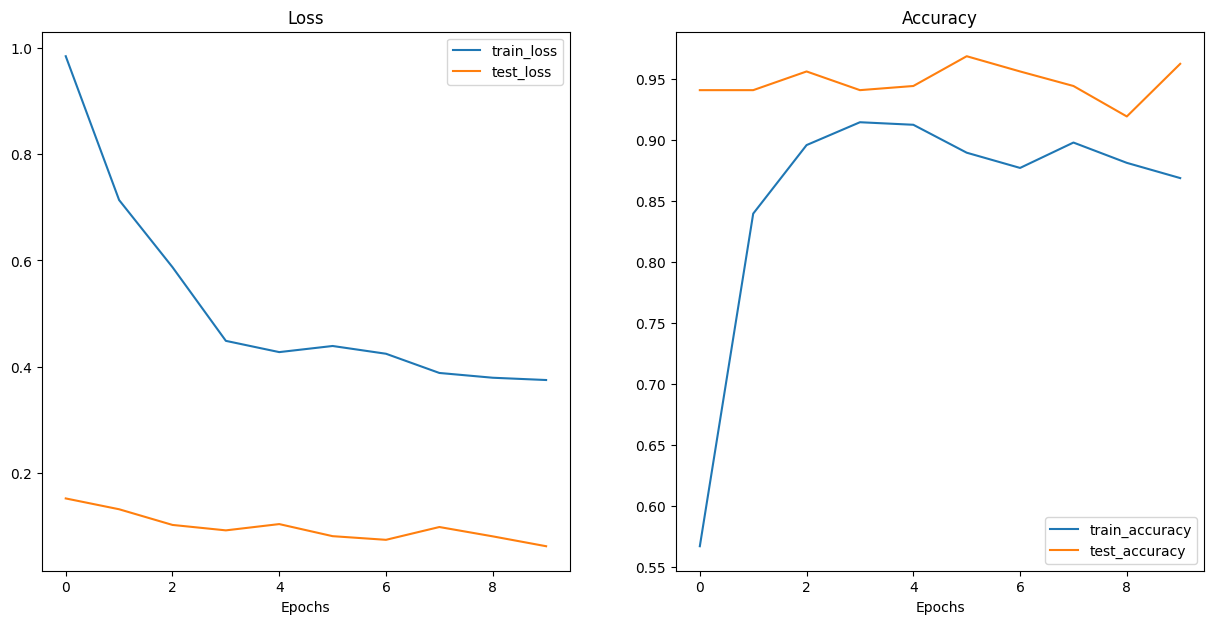

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

The loss curves seem to be very good with the `test_loss` and `test_accuracy` values almost optimal.  

### 3.5 Saving EffNetB2 feature extractor

In [15]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 EffNetB2 feature extractor size

Since one of our most important metrics is speed, the size of the model can influence the inference speed.

Generally, if a model has more parameters, it generally performs more operations and each operation requires more computing power.

Given that the goal is for the model to work with limited computing power such as on a mobile device or web browser, generally, the smaller the size the better.

In [16]:
from pathlib import Path
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")


Pretrained EffNetB2 feature extractor model size: 29 MB


### 3.7 EffNetB2 feature extractor stats

So far we have identified the `test_loss`, `test_accuracy` and `model_size` metrics. To make it easier to compare with the upcoming feature extractor, we can condense it into a dictionary, alongside any other meaningful metrics.

An extra metric we can include are the total number of parameters. This can be calculated by counting the number of elements (or patterns/weights) in `effnetb2.parameteres()` by accessing said number using the `torch.numel()` method.



In [17]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.06278705596923828,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

Based on these metrics, we have already met the first criteria which aimed for a performance with at least 95% accuracy.

## 4. Creating a ViT feature extractor